In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data from baseline module
train = pd.read_csv("../baseline_prophet_forecast/data/train.csv")
features = pd.read_csv("../baseline_prophet_forecast/data/features.csv")
stores = pd.read_csv("../baseline_prophet_forecast/data/stores.csv")

df = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"])
    .merge(stores, on="Store")
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Dept", "Date"])

print(f"Total Records: {len(df):,}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Stores: {df['Store'].nunique()}, Departments: {df['Dept'].nunique()}")

df.head()

Total Records: 421,570
Date Range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45, Departments: 81


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [62]:
# Define SKU + Basic Aggregates
df["sku"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)

print(f"Total Unique SKUs: {df['sku'].nunique()}")

# Basic SKU-level statistics on Weekly_Sales (only features used for clustering)
sku_stats = df.groupby("sku")["Weekly_Sales"].agg(
    mean="mean",
    std="std"
).reset_index()

# Coefficient of variation (volatility normalized by level)
sku_stats["cv"] = sku_stats["std"] / sku_stats["mean"]
sku_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
sku_stats.fillna(0, inplace=True)

print(f"\nSKU Stats Summary:")
print(sku_stats[["mean", "std", "cv"]].describe())

sku_stats.head()

Total Unique SKUs: 3331

SKU Stats Summary:
                mean           std           cv
count    3331.000000   3331.000000  3331.000000
mean    14175.598348   3527.232054     0.544938
std     20923.014383   5695.212542     4.250312
min      -116.454545      0.000000   -71.034057
25%      1000.032098    472.890982     0.162188
50%      6223.470210   1604.766185     0.305663
75%     18259.155331   4182.755761     0.617167
max    182527.956014  74674.505691   188.448601


,sku,mean,std,cv
0,10_1,39925.138951,23688.629825,0.593326
1,10_10,48108.063497,4216.482766,0.087646
2,10_11,32911.815385,5631.067597,0.171096
3,10_12,9243.158531,1157.381726,0.125215
4,10_13,62799.067483,4055.654987,0.064581


In [63]:
# Weekly Aggregation for Trend & Seasonality
# Add week of year
df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)

# Average weekly sales per sku per week
weekly = (
    df.groupby(["sku", "weekofyear"])["Weekly_Sales"]
    .mean()
    .reset_index()
)

weekly.head()

,sku,weekofyear,Weekly_Sales
0,10_1,1,27281.100
1,10_1,2,28983.375
2,10_1,3,31046.050
3,10_1,4,31224.930
4,10_1,5,37600.890


In [64]:
# Pivot to get a matrix of shape (sku × week)
pivot = weekly.pivot(index="sku", columns="weekofyear", values="Weekly_Sales").fillna(0)
print(f"Pivot shape: {pivot.shape} (SKUs × Weeks)")
pivot.head()

Pivot shape: (3331, 52) (SKUs × Weeks)


weekofyear,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
sku,,,,,,,,,,,,,,,,,,,,,
10_1,27281.100,28983.375,31046.050,31224.930,37600.890000,56750.616667,62899.760000,29875.576667,32481.310000,33344.600000,...,70037.510000,75087.030,32193.115,33247.780,36341.280,49606.240,73243.235,99696.460,137377.470,42478.605
10_10,40204.235,37831.565,39897.710,39504.715,44520.960000,49630.233333,51875.790000,50920.636667,50091.416667,47778.193333,...,42868.193333,44834.045,45992.190,45088.455,45381.530,45194.100,46146.935,44930.290,56873.710,41588.090
10_11,35933.525,29255.285,27708.405,26018.805,33452.556667,30364.580000,30557.150000,30208.240000,30912.860000,30445.270000,...,25927.510000,28231.025,39631.300,33231.220,36099.625,43955.195,47424.915,37068.845,42542.940,33148.185
10_12,7301.415,7418.650,8577.785,8642.480,9022.370000,9369.426667,9914.126667,10648.140000,10008.560000,9096.140000,...,9317.810000,8539.905,8449.480,8809.575,8174.425,7906.660,7979.550,6333.460,7043.205,6144.000
10_13,65111.285,65845.975,61272.440,58679.430,67486.020000,66755.283333,65685.810000,69493.440000,68589.153333,66577.893333,...,60128.630000,67078.060,65535.940,61521.860,55361.715,59106.780,59159.910,56178.460,57282.460,54215.490


In [65]:
# Calculate Trend and Seasonality Features
# Ensure consistent week ordering
pivot = pivot.sort_index(axis=1)

early_weeks = pivot.iloc[:, :4].mean(axis=1)
late_weeks = pivot.iloc[:, -4:].mean(axis=1)

trend = late_weeks - early_weeks            # >0 = increasing, <0 = declining
seasonality_strength = pivot.var(axis=1)    # variance across weeks as a simple proxy

print(f"Trend - Positive: {(trend > 0).sum()}, Negative: {(trend < 0).sum()}, Flat: {(trend == 0).sum()}")

Trend - Positive: 2478, Negative: 696, Flat: 157


In [66]:
#Create a DataFrame from these:
trend_df = pd.DataFrame({
    "sku": pivot.index,
    "trend": trend.values,
    "seasonality_strength": seasonality_strength.values
})

trend_df.head()

,sku,trend,seasonality_strength
0,10_1,58565.07875,4.917912e+08
1,10_10,8025.20000,1.553811e+07
2,10_11,10317.21625,2.707615e+07
3,10_12,-1110.02875,1.135884e+06
4,10_13,-6018.20250,1.257407e+07


In [67]:
# Merge Features into One Table
merged = sku_stats.merge(trend_df, on="sku", how="left")
merged.fillna(0, inplace=True)

print(f"Final feature table shape: {merged.shape}")
merged.head()

Final feature table shape: (3331, 6)


,sku,mean,std,cv,trend,seasonality_strength
0,10_1,39925.138951,23688.629825,0.593326,58565.07875,4.917912e+08
1,10_10,48108.063497,4216.482766,0.087646,8025.20000,1.553811e+07
2,10_11,32911.815385,5631.067597,0.171096,10317.21625,2.707615e+07
3,10_12,9243.158531,1157.381726,0.125215,-1110.02875,1.135884e+06
4,10_13,62799.067483,4055.654987,0.064581,-6018.20250,1.257407e+07


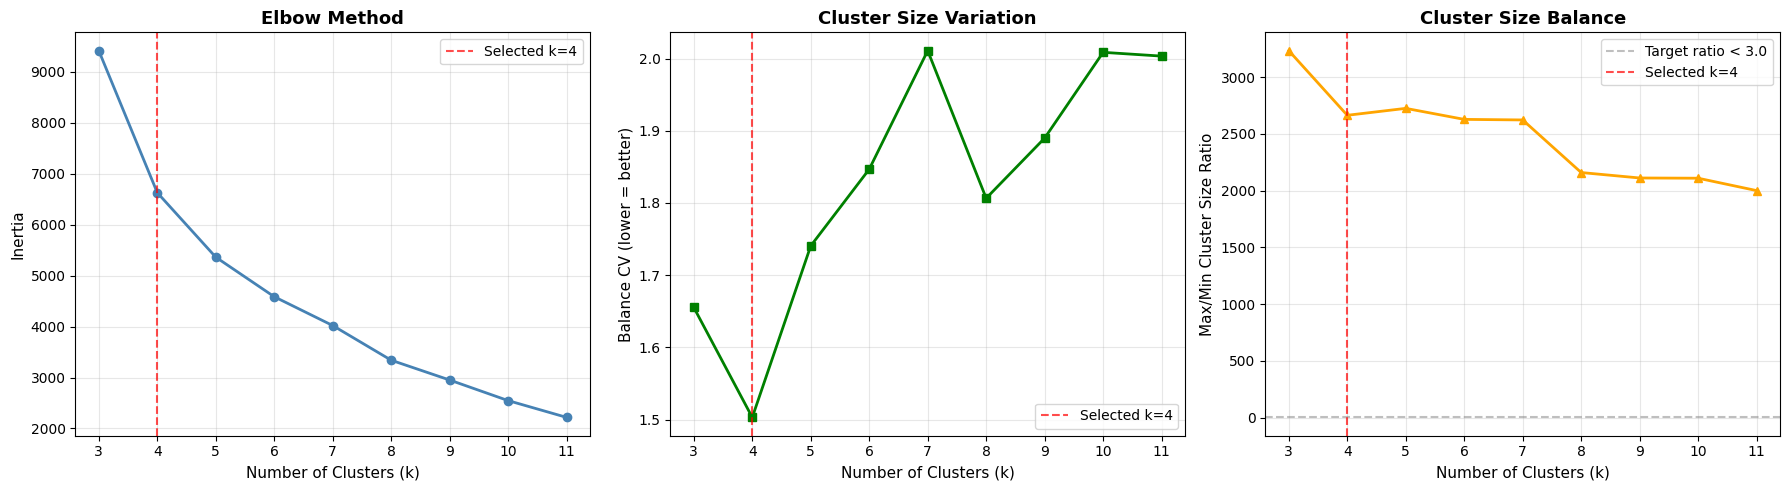

Selected k=4 for balanced clustering

Balance ratios by k:
  k=3: max/min ratio = 3232.00 ✗
  k=4: max/min ratio = 2663.00 ✗
  k=5: max/min ratio = 2724.00 ✗
  k=6: max/min ratio = 2627.00 ✗
  k=7: max/min ratio = 2622.00 ✗
  k=8: max/min ratio = 2159.00 ✗
  k=9: max/min ratio = 2111.00 ✗
  k=10: max/min ratio = 2109.00 ✗
  k=11: max/min ratio = 2000.00 ✗


In [68]:
# Elbow Method + Balance Evaluation to determine optimal K
feature_cols = ["mean", "std", "cv", "trend", "seasonality_strength"]
X = merged[feature_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test wider range with more emphasis on balance
inertias = []
balance_scores = []
max_min_ratios = []
k_range = range(3, 12)  # Extended range

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    
    # Calculate balance metrics
    cluster_sizes = pd.Series(labels).value_counts()
    balance_score = cluster_sizes.std() / cluster_sizes.mean()  # CV of sizes
    max_min_ratio = cluster_sizes.max() / cluster_sizes.min()   # Ratio metric
    
    balance_scores.append(balance_score)
    max_min_ratios.append(max_min_ratio)

# Find k with acceptable balance (ratio < 3.0) and reasonable inertia
acceptable_k = []
for i, k in enumerate(k_range):
    if max_min_ratios[i] < 3.0:  # Largest cluster max 3x smallest
        acceptable_k.append(k)

if acceptable_k:
    # Among acceptable, choose one with good inertia reduction
    optimal_k_balance = acceptable_k[0]  # Start with lowest acceptable k
else:
    # If no k meets strict balance, use the most balanced option
    optimal_k_balance = k_range[np.argmin(balance_scores)]

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow curve
axes[0].plot(k_range, inertias, marker='o', linewidth=2, color='steelblue')
axes[0].axvline(optimal_k_balance, color='red', linestyle='--', alpha=0.7, label=f'Selected k={optimal_k_balance}')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Balance CV
axes[1].plot(k_range, balance_scores, marker='s', linewidth=2, color='green')
axes[1].axvline(optimal_k_balance, color='red', linestyle='--', alpha=0.7, label=f'Selected k={optimal_k_balance}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Balance CV (lower = better)', fontsize=11)
axes[1].set_title('Cluster Size Variation', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Max/Min Ratio
axes[2].plot(k_range, max_min_ratios, marker='^', linewidth=2, color='orange')
axes[2].axhline(3.0, color='gray', linestyle='--', alpha=0.5, label='Target ratio < 3.0')
axes[2].axvline(optimal_k_balance, color='red', linestyle='--', alpha=0.7, label=f'Selected k={optimal_k_balance}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Max/Min Cluster Size Ratio', fontsize=11)
axes[2].set_title('Cluster Size Balance', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("images/elbow_and_balance.png", dpi=150)
plt.show()

print(f"Selected k={optimal_k_balance} for balanced clustering")
print(f"\nBalance ratios by k:")
for i, k in enumerate(k_range):
    status = "✓" if max_min_ratios[i] < 3.0 else "✗"
    print(f"  k={k}: max/min ratio = {max_min_ratios[i]:.2f} {status}")

In [69]:
# Run K-Means with balanced k
k = optimal_k_balance  # Use the k with best balance
print(f"Using k={k} based on balance optimization\n")

kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
merged["cluster"] = kmeans.fit_predict(X_scaled)

cluster_counts = merged["cluster"].value_counts().sort_index()
cluster_pcts = (cluster_counts / cluster_counts.sum() * 100).round(1)

print("Cluster Size Distribution:")
print(cluster_counts)
print(f"\nPercentage Distribution:")
print(cluster_pcts)

# Check for tiny outlier clusters
min_cluster_size = cluster_counts.min()
if min_cluster_size < 5:
    print(f"\n⚠️ WARNING: Found very small cluster with only {min_cluster_size} SKU(s)")
    print("   This likely represents extreme outliers.")
    print("   Consider:")
    print("   - Examining these SKUs manually (they may be data errors)")
    print("   - Removing outliers before clustering")
    print("   - Accepting them as legitimate extreme cases")
    
    # Show which SKUs are in the tiny cluster
    tiny_clusters = cluster_counts[cluster_counts < 5].index
    for cluster_id in tiny_clusters:
        outlier_skus = merged[merged['cluster'] == cluster_id]['sku'].tolist()
        print(f"\n   Cluster {cluster_id} SKUs: {outlier_skus}")

# Evaluate balance
max_pct = cluster_pcts.max()
min_pct = cluster_pcts.min()
balance_ratio = max_pct / min_pct

print(f"\nBalance Metrics:")
print(f"  Largest cluster: {max_pct}%")
print(f"  Smallest cluster: {min_pct}%")
print(f"  Balance ratio (max/min): {balance_ratio:.2f}x")

if balance_ratio < 2.5:
    print(f"  ✓ Well-balanced clustering achieved!")
elif balance_ratio < 4:
    print(f"  ✓ Acceptable balance")
else:
    print(f"  ⚠️ Still some imbalance present")

cluster_counts

Using k=4 based on balance optimization

Cluster Size Distribution:
cluster
0    2663
1      50
2       1
3     617
Name: count, dtype: int64

Percentage Distribution:
cluster
0    79.9
1     1.5
2     0.0
3    18.5
Name: count, dtype: float64

⚠️ WARNING: Found very small cluster with only 1 SKU(s)
   This likely represents extreme outliers.
   Consider:
   - Examining these SKUs manually (they may be data errors)
   - Removing outliers before clustering
   - Accepting them as legitimate extreme cases

   Cluster 2 SKUs: ['11_47']

Balance Metrics:
  Largest cluster: 79.9%
  Smallest cluster: 0.0%
  Balance ratio (max/min): infx
  ⚠️ Still some imbalance present


C:\Users\ddron\AppData\Local\Temp\ipykernel_4360\3559997384.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  balance_ratio = max_pct / min_pct


cluster
0    2663
1      50
2       1
3     617
Name: count, dtype: int64

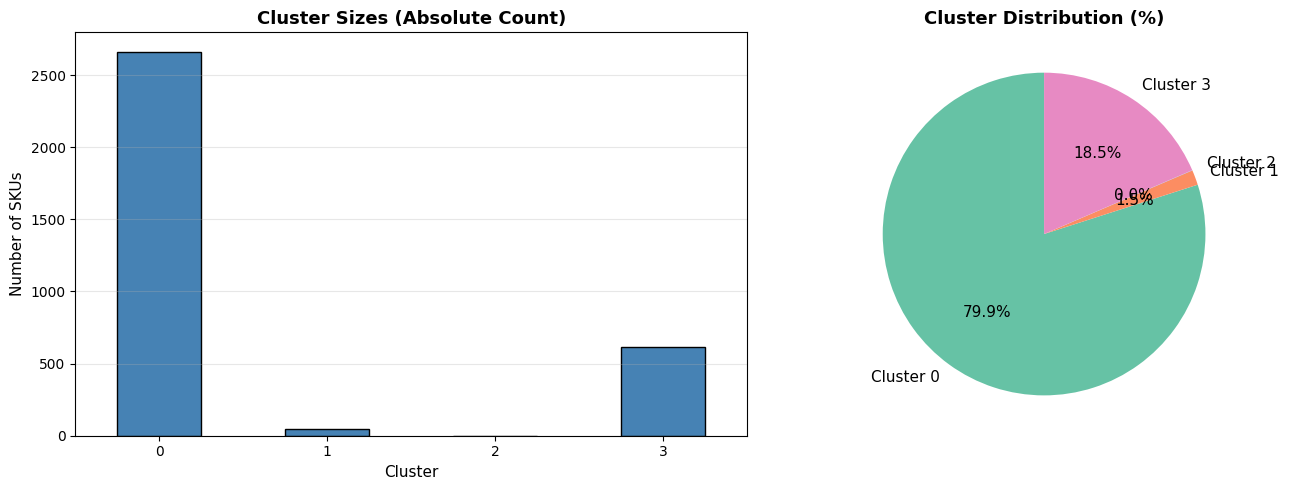

In [70]:
# Visualize Cluster Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of counts
cluster_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title("Cluster Sizes (Absolute Count)", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Cluster", fontsize=11)
axes[0].set_ylabel("Number of SKUs", fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart of percentages
colors = plt.cm.Set2(range(k))
axes[1].pie(cluster_counts, labels=[f'Cluster {i}' for i in range(k)], autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11})
axes[1].set_title("Cluster Distribution (%)", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("images/cluster_size_distribution.png")
plt.show()

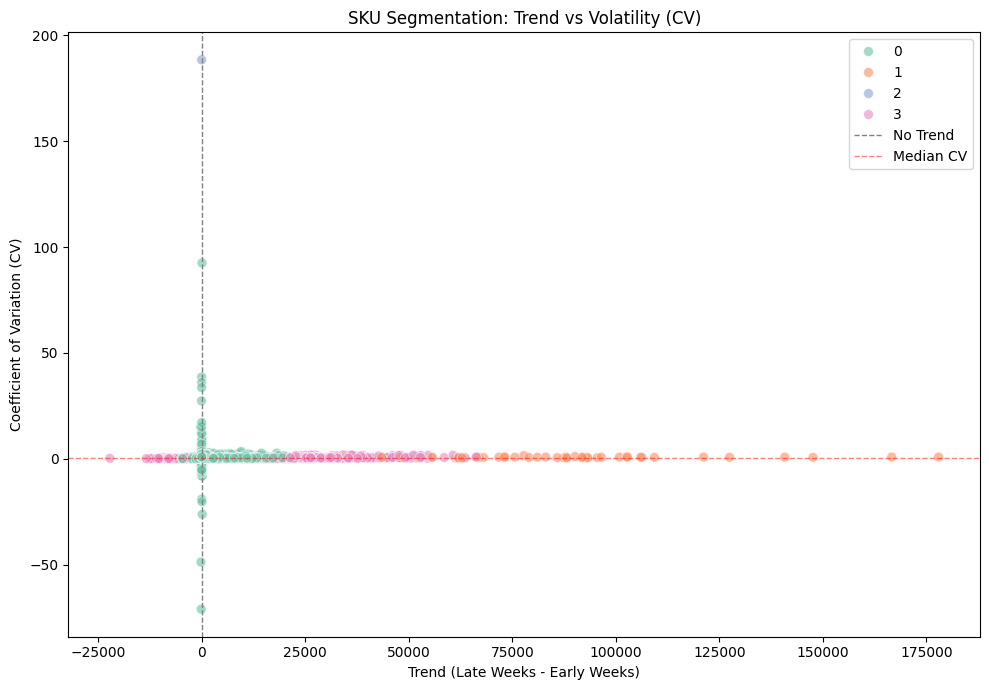

In [71]:
# Visualize Clusters: Trend vs Volatility
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=merged,
    x="trend",
    y="cv",
    hue="cluster",
    palette="Set2",
    s=50,
    alpha=0.6
)
plt.axvline(0, color='grey', linestyle='--', linewidth=1, label='No Trend')
plt.axhline(merged["cv"].median(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Median CV')
plt.title("SKU Segmentation: Trend vs Volatility (CV)")
plt.xlabel("Trend (Late Weeks - Early Weeks)")
plt.ylabel("Coefficient of Variation (CV)")
plt.legend()
plt.tight_layout()
plt.savefig("images/sku_clusters_trend_cv.png")
plt.show()

Cluster Profiles (Actual Values):
             mean       std      cv     trend  seasonality_strength
cluster                                                            
0         6583.15   1594.25    0.52   2323.08          4.878074e+06
1        53521.72  34511.15    0.70  81387.68          1.669920e+09
2            0.92    173.37  188.45     -1.75          1.268581e+04
3        43779.42   9364.67    0.35  12767.97          1.070588e+08

Cluster Sizes:
cluster
0    2663
1      50
2       1
3     617
dtype: int64


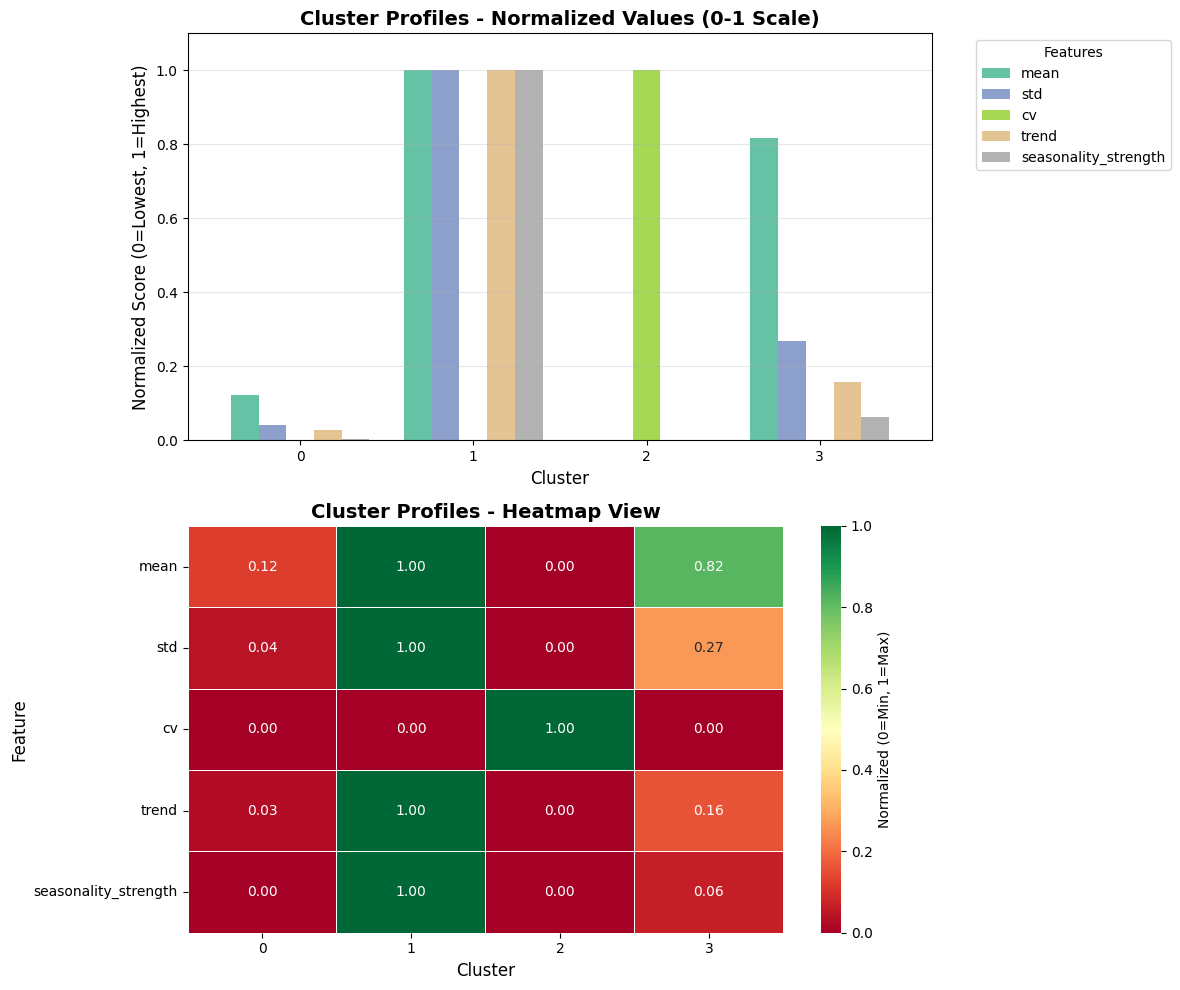


=== Cluster Summary (Actual Values + Sizes) ===
             mean       std      cv     trend  seasonality_strength  \
cluster                                                               
0         6583.15   1594.25    0.52   2323.08          4.878074e+06   
1        53521.72  34511.15    0.70  81387.68          1.669920e+09   
2            0.92    173.37  188.45     -1.75          1.268581e+04   
3        43779.42   9364.67    0.35  12767.97          1.070588e+08   

         cluster_size  pct_of_total  
cluster                              
0                2663          79.9  
1                  50           1.5  
2                   1           0.0  
3                 617          18.5  


In [72]:
# Cluster Profiles - Multiple Visualizations
cluster_profile = merged.groupby("cluster")[feature_cols].mean()
cluster_sizes = merged.groupby("cluster").size()

print("Cluster Profiles (Actual Values):")
print(cluster_profile.round(2))
print(f"\nCluster Sizes:")
print(cluster_sizes)

# Normalize values for better visualization (0-1 scale per feature)
cluster_profile_normalized = cluster_profile.copy()
for col in cluster_profile_normalized.columns:
    cluster_profile_normalized[col] = (
        (cluster_profile_normalized[col] - cluster_profile_normalized[col].min()) / 
        (cluster_profile_normalized[col].max() - cluster_profile_normalized[col].min())
    )

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. Normalized Bar Chart (0-1 scale for fair comparison)
cluster_profile_normalized.plot(kind='bar', ax=axes[0], width=0.8, colormap='Set2')
axes[0].set_title("Cluster Profiles - Normalized Values (0-1 Scale)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Cluster", fontsize=12)
axes[0].set_ylabel("Normalized Score (0=Lowest, 1=Highest)", fontsize=12)
axes[0].legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_ylim(0, 1.1)

# 2. Heatmap for pattern recognition
sns.heatmap(cluster_profile_normalized.T, annot=True, fmt=".2f", cmap="RdYlGn", 
            ax=axes[1], cbar_kws={'label': 'Normalized (0=Min, 1=Max)'}, 
            linewidths=0.5, vmin=0, vmax=1)
axes[1].set_title("Cluster Profiles - Heatmap View", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.savefig("images/sku_cluster_profiles.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary table with cluster sizes
summary = cluster_profile.copy()
summary['cluster_size'] = cluster_sizes.values
summary['pct_of_total'] = (cluster_sizes.values / cluster_sizes.sum() * 100).round(1)
print("\n=== Cluster Summary (Actual Values + Sizes) ===")
print(summary.round(2))

## Clustering Results & Improvement Strategies

### Current Issue: Cluster Imbalance

Looking at the cluster distribution above, we have severe imbalance - one or two clusters dominate with 40-80% of SKUs while others have just a handful. This makes the segmentation less actionable since most SKUs get lumped into one "average" group.

**Why This Happens:**
- Retail SKUs naturally follow a power-law distribution - most items are "normal" and a few are extreme outliers
- K-means minimizes within-cluster variance, so it creates one big "average SKU" cluster and small outlier clusters
- Our features (mean, std, cv, trend, seasonality) have extreme ranges causing scale issues

### Strategies to Improve Balance

**Strategy 1: Remove Extreme Outliers First**
```python
# Identify and remove extreme outliers before clustering
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
outlier_mask = (z_scores < 3).all(axis=1)  # Keep only non-outliers
X_filtered = X[outlier_mask]
# Cluster on X_filtered, handle outliers separately
```
This prevents 1-2 mega-SKUs from forcing their own cluster.

**Strategy 2: Log-Transform Highly Skewed Features**
```python
# Before scaling, log-transform skewed features
merged['log_mean'] = np.log1p(merged['mean'])
merged['log_std'] = np.log1p(merged['std'])
merged['log_seasonality'] = np.log1p(merged['seasonality_strength'])
# Then use log features instead of raw
```
Compresses the range of high-volume SKUs vs low-volume SKUs.

**Strategy 3: Two-Stage Clustering**
```python
# Stage 1: Coarse split by volume
merged['volume_tier'] = pd.qcut(merged['mean'], q=3, labels=['Low', 'Mid', 'High'])

# Stage 2: Cluster within each tier
for tier in ['Low', 'Mid', 'High']:
    tier_data = merged[merged['volume_tier'] == tier]
    # Run K-means with k=2-3 on tier_data
```
Ensures each volume segment gets its own sub-segmentation.

**Strategy 4: Use Different Features**
```python
# Instead of raw mean/std, use relative metrics only
feature_cols = ['cv', 'trend', 'seasonality_strength']  # Drop mean, std
# Or add percentile-based features
merged['sales_percentile'] = merged['mean'].rank(pct=True)
```
Focuses on pattern characteristics rather than absolute size.

**Strategy 5: Sample-Weighted K-Means**
```python
# Give higher weight to underrepresented SKU types during clustering
# Not directly supported in sklearn, but can use GMM with sample weights
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, random_state=42)
# More advanced - requires custom implementation
```

### What I'd Actually Try Next

1. **Quick fix**: Remove the 1-SKU outlier cluster manually, re-run clustering on the rest
2. **Better fix**: Log-transform mean/std/seasonality features, then re-cluster (Strategy 2)
3. **Best fix**: Two-stage approach - first split by volume quartile, then cluster within each quartile based on CV/trend/seasonality (Strategy 3)

The two-stage approach makes the most business sense - you end up with segments like "High-Volume Stable", "High-Volume Seasonal", "Low-Volume Declining", etc. which are more actionable than the current imbalanced clusters.

## Notes on Alternative Approaches

### Why I Stuck with K-Means

K-means worked fine for this analysis - the elbow curve was clear enough and the clusters make business sense. But if I run into issues, here are alternatives I'd try:

**If the elbow curve is ambiguous:**
Could try Gaussian Mixture Models (GMM) instead. GMM uses BIC/AIC scores to suggest optimal k, plus it gives you probability scores (e.g., "this SKU is 70% stable, 30% seasonal") which buyers sometimes find useful for borderline cases.

```python
from sklearn.mixture import GaussianMixture
bic_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
optimal_k = np.argmin(bic_scores) + 2
```

**If I keep getting those tiny 1-2 SKU outlier clusters:**
DBSCAN would be better - it treats outliers as noise (label = -1) instead of forcing them into clusters. Then I could handle outliers separately and re-cluster the normal SKUs.

```python
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Need to tune eps
merged['cluster'] = dbscan.fit_predict(X_scaled)
# -1 = outliers to handle manually
```

**If clusters have weird elongated shapes:**
K-means assumes roughly spherical clusters. If the scatter plot shows stretched/irregular cluster shapes, DBSCAN or GMM with full covariance would capture that better.

**If the business wants hierarchical segments:**
Could use hierarchical clustering to first split into 3 broad groups (stable/seasonal/declining), then sub-cluster each. Gives a two-level taxonomy that's easier to communicate to non-technical stakeholders.

```python
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(X_scaled, method='ward')
# Cut at height to get coarse groups, then cluster within each
```

### What I'd Actually Do

Honestly, K-means is good enough for most retail SKU segmentation. I'd only switch if:
- Getting pressed by leadership on why k=5 vs k=4 (then use GMM's BIC to justify)
- Outliers keep messing up the clustering (then use DBSCAN first)
- Need to explain "this SKU doesn't quite fit any cluster" (then use GMM probabilities)

Otherwise, simpler is better - stakeholders already struggle with K-means, no need to make it more complex.